Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2719/2719 [10:00<00:00,  4.53it/s]


Epoch 1 Loss 2395.382238805294 Accuracy 72.41272286275907


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2719/2719 [09:53<00:00,  4.58it/s]


Epoch 2 Loss 630.8757236599922 Accuracy 92.22121320106216


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2719/2719 [10:06<00:00,  4.48it/s]


Epoch 3 Loss 414.03841871907935 Accuracy 94.92372949547665


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2719/2719 [17:51<00:00,  2.54it/s]


Epoch 4 Loss 351.8863570756512 Accuracy 95.85598841286081


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2719/2719 [15:49<00:00,  2.86it/s]


Epoch 5 Loss 284.43682385594 Accuracy 96.59857689699172


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2719/2719 [15:49<00:00,  2.86it/s]


Epoch 6 Loss 245.9210855732963 Accuracy 97.10436471900037


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2719/2719 [16:01<00:00,  2.83it/s]


Epoch 7 Loss 237.78566476589185 Accuracy 97.3595576655593


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2719/2719 [18:09<00:00,  2.50it/s]


Epoch 8 Loss 219.46216863963855 Accuracy 97.68602071431035


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2719/2719 [09:44<00:00,  4.65it/s]


Epoch 9 Loss 209.7433880164408 Accuracy 97.77568310093916


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2719/2719 [09:56<00:00,  4.56it/s]


Epoch 10 Loss 192.30061203983587 Accuracy 97.93431655420551
Most common predictions: [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]
Labels in test set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28]

Classification Report
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00  

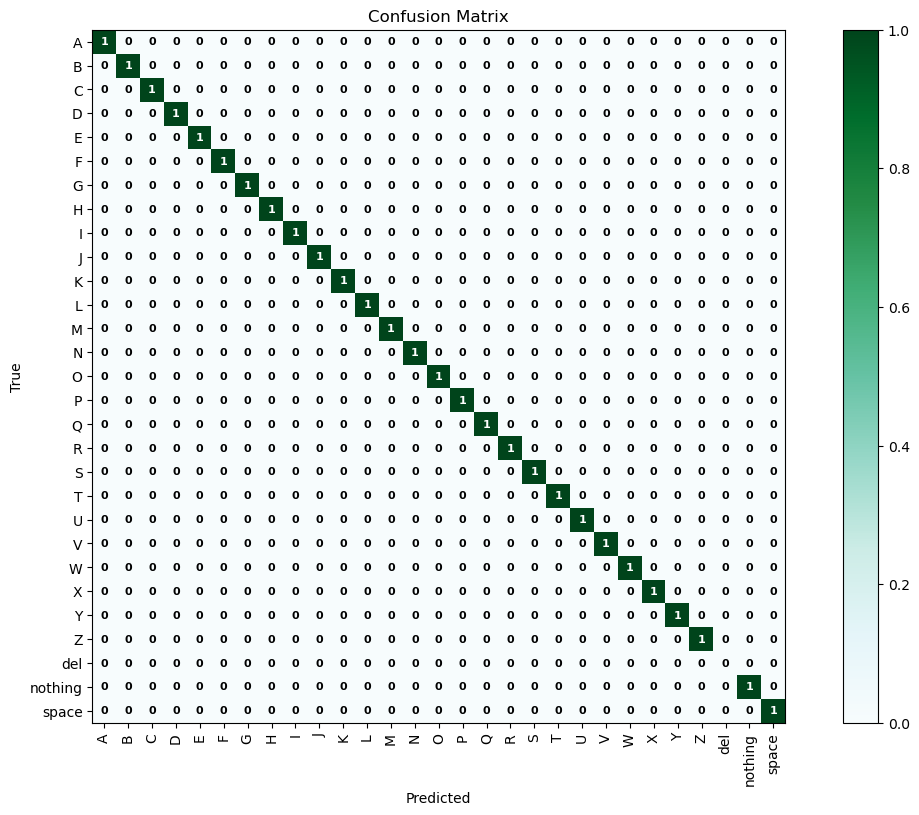

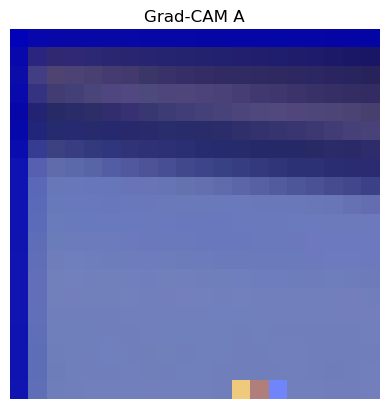

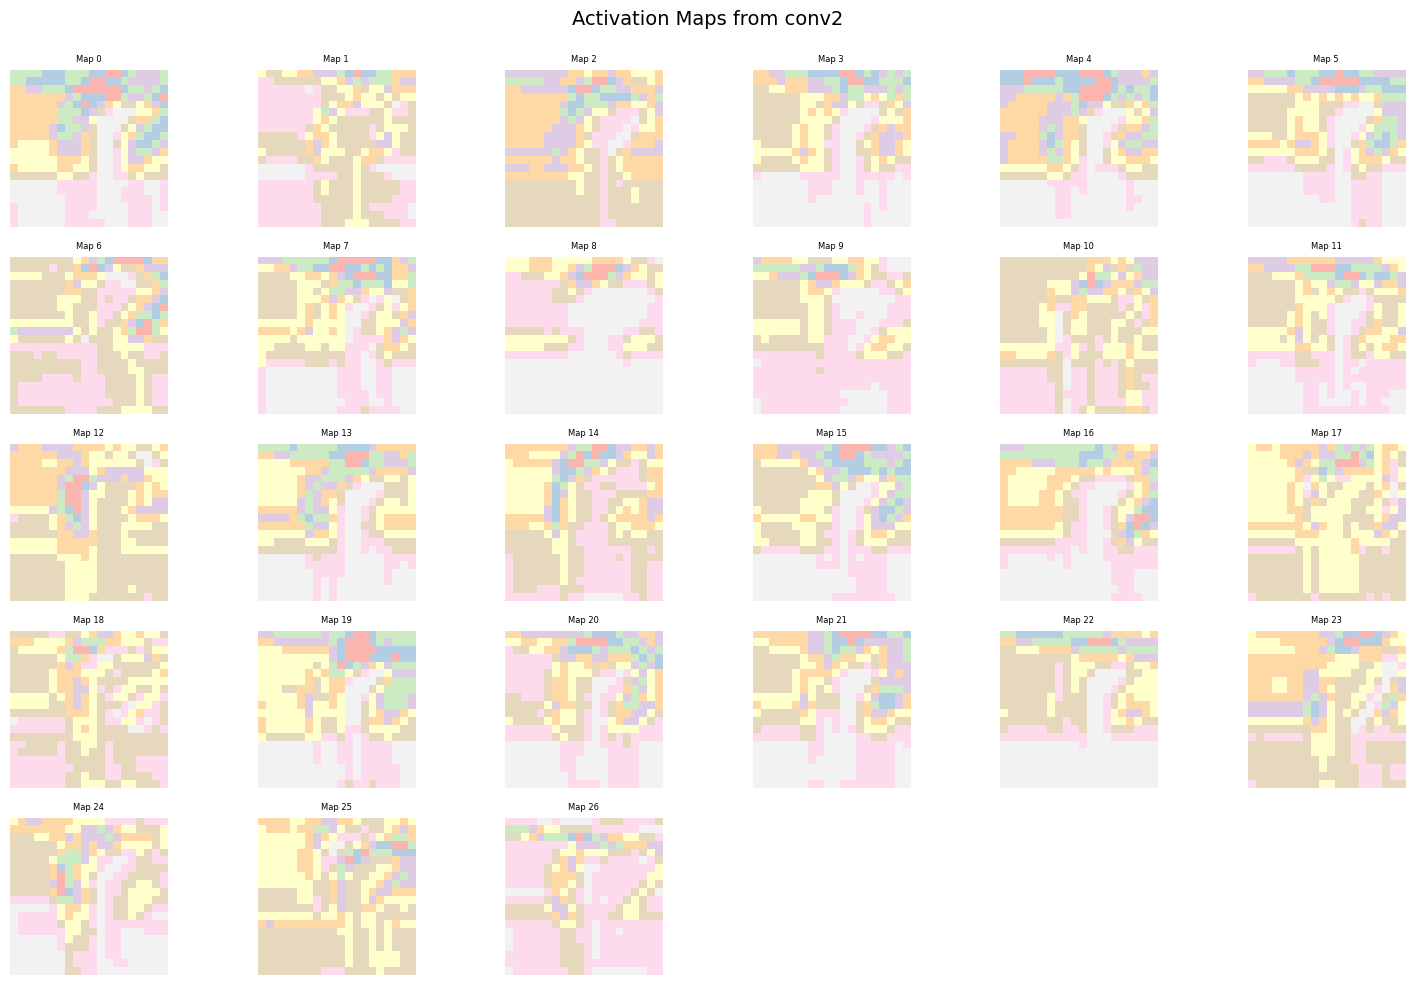

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from collections import Counter

traindir = r"C:\Users\Dell\Desktop\asl_alphabet_train"
testdir = r"C:\Users\Dell\Desktop\asl_alphabet_test"

transform = T.Compose([
    T.Resize((100, 100)),
    T.ToTensor()
])

trainds = torchvision.datasets.ImageFolder(root = traindir, transform = transform)
classes = trainds.classes
lbl2idx = {lbl.upper(): i for i, lbl in enumerate(classes)}
idx2lbl = {i: lbl for lbl, i in lbl2idx.items()}

class ASLTestDS(Dataset):
    def __init__(self, folder, transform = None):
        self.path = folder
        self.tf = transform
        self.files = [f for f in os.listdir(folder)
                      if f.lower().endswith(('.jpg', '.png')) and f.split('_')[0].upper() in lbl2idx]
        self.labels = [self.get_lbl(f) for f in self.files]

    def get_lbl(self, fname):
        lbl = fname.split('_')[0].upper()
        return lbl2idx[lbl]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        img = Image.open(os.path.join(self.path, self.files[i])).convert("RGB")
        lbl = self.labels[i]
        if self.tf:
            img = self.tf(img)
        return img, lbl

testds = ASLTestDS(testdir, transform)
train_dl = DataLoader(trainds, batch_size = 32, shuffle = True, num_workers = 2)
test_dl = DataLoader(testds, batch_size = 32, shuffle = False)

class ASLNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3, 27, 5)
        self.p1 = nn.MaxPool2d(4, 4)
        self.c2 = nn.Conv2d(27, 27, 5)
        self.p2 = nn.MaxPool2d(2, 2)
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 100, 100)
            dummy = self.p1(F.relu(self.c1(dummy)))
            dummy = self.p2(F.relu(self.c2(dummy)))
            self.flat_dim = dummy.view(1, -1).shape[1]
        self.f1 = nn.Linear(self.flat_dim, 270)
        self.drop = nn.Dropout(0.5)
        self.f2 = nn.Linear(270, len(classes))

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = self.p1(x)
        x = F.relu(self.c2(x))
        x = self.p2(x)
        x = x.view(x.size(0), -1)
        x = self.drop(self.f1(x))
        return self.f2(x)

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASLNet().to(dev)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr = 0.001)

for ep in range(10):
    model.train()
    total = 0
    correct = 0
    run_loss = 0
    for x, y in tqdm(train_dl, desc = "Epoch " + str(ep + 1)):
        x, y = x.to(dev), y.to(dev)
        out = model(x)
        loss = loss_fn(out, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        run_loss = run_loss + loss.item()
        preds = out.argmax(dim = 1)
        total = total + y.size(0)
        correct = correct + (preds == y).sum().item()
    acc = 100 * correct / total
    print("Epoch", ep + 1, "Loss", run_loss, "Accuracy", acc)

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for x, y in test_dl:
        x = x.to(dev)
        out = model(x)
        preds = out.argmax(dim = 1)
        y_true = y_true + y.numpy().tolist()
        y_pred = y_pred + preds.cpu().numpy().tolist()

print("Most common predictions:", Counter(y_pred).most_common(5))
print("Labels in test set:", sorted(set(y_true)))

print("\nClassification Report")
print(classification_report(
    y_true,
    y_pred,
    labels = list(range(len(classes))),
    target_names = classes,
    zero_division = 0
))

confmat = confusion_matrix(
    y_true,
    y_pred,
    labels = list(range(len(classes)))
)

plt.figure(figsize = (15, 9))
plt.imshow(confmat, interpolation = 'nearest', cmap = 'BuGn')
plt.title('Confusion Matrix')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation = 90)
plt.yticks(ticks, classes)

thresh = confmat.max() / 2
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confmat[i, j], 'd'),
                 ha = "center", va = "center",
                 fontsize = 8,
                 fontweight = 'bold',
                 color = "white" if confmat[i, j] > thresh else "black")

plt.ylabel('True')
plt.xlabel('Predicted')
plt.savefig("conf_matrix.png")
plt.show()

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.layer = target_layer
        self.grad = None
        self.act = None
        self.layer.register_forward_hook(self.save_act)
        self.layer.register_full_backward_hook(self.save_grad)

    def save_act(self, module, inp, out):
        self.act = out

    def save_grad(self, module, grad_in, grad_out):
        self.grad = grad_out[0]

    def generate(self, x, cls_idx):
        self.model.eval()
        x.requires_grad_()
        self.model.zero_grad()
        out = self.model(x)
        out[0, cls_idx].backward()
        grad = self.grad[0]
        act = self.act[0]
        wts = torch.mean(grad, dim = [1, 2])
        for i in range(act.size(0)):
            act[i] = act[i] * wts[i]
        heat = torch.mean(act, dim = 0).detach().cpu().numpy()
        heat = np.maximum(heat, 0)
        heat = heat / np.max(heat)
        return heat

img, lbl = testds[0]
inp = img.unsqueeze(0).to(dev)
pred = model(inp).argmax().item()
cam = GradCAM(model, model.c2)
heatmap = cam.generate(inp, pred)

plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.imshow(heatmap, cmap = 'jet', alpha = 0.5)
plt.title("Grad-CAM " + idx2lbl[pred])
plt.axis('off')
plt.savefig("gradcam.png")
plt.show()

def show_activation_maps(model, image_tensor, layer, layer_name):
    activation = {}

    def hook_fn(module, input, output):
        activation[layer_name] = output.detach().cpu()

    hook = layer.register_forward_hook(hook_fn)

    model.eval()
    with torch.no_grad():
        _ = model(image_tensor.to(dev))

    act = activation[layer_name].squeeze(0)  
    num_maps = act.size(0)
    cols = 6
    rows = (num_maps + cols - 1) // cols

    plt.figure(figsize=(15, rows * 2))
    for i in range(num_maps):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(act[i], cmap = 'Pastel1')
        plt.axis('off')
        plt.title(f"Map {i}", fontsize=6)

    plt.suptitle(f"Activation Maps from {layer_name}", fontsize = 14)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.92)
    plt.savefig("activation_maps.png")
    plt.show()

show_activation_maps(model, inp, model.c2, 'conv2')